# Project 2

实现 TransE 算法，在一个不少于 1000 个实体的知识图谱中展示其功效。

## Environment Setup

Load Python libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Utility functions defined in `utils.py`
from utils import (
    dict_to_namespace,
    read_toml,
    seed_everything,
    download_files,
    extract_file,
    move_content,
)

Load dataset/model configurations:

In [2]:
config_files = sorted(os.listdir('configs'))
configs = {
    filename.split('.')[0]: dict_to_namespace(
        read_toml(os.path.join('configs', filename))
    )
    for filename in config_files
}

DEBUG = False

## Datasets

We use the de-facto standard datasets for knowledge graph embedding, FB15k-237 and WN18-RR. These 2 datasets are sampled from Freebase and WordNet respectively after removing inverse relations and performing some other preprocessing steps. 

The data files are in the format of TSV (tab-separated values), where each line represents a triplet (head entity, relation, tail entity).

In [3]:
class TripletDataset:
    def __init__(self):
        self.train_df: pd.DataFrame | None = None
        self.val_df: pd.DataFrame | None = None
        self.test_df: pd.DataFrame | None = None

        self.n_entities: int | None = None
        self.n_relations: int | None = None

        self.entity2id: dict[str, int] | None = None
        self.relation2id: dict[str, int] | None = None
        self.id2entity: dict[int, str] | None = None
        self.id2relation: dict[int, str] | None = None

        self.hrt_train: np.ndarray | None = None
        self.hrt_val: np.ndarray | None = None
        self.hrt_test: np.ndarray | None = None


def load_triplets(dataset: TripletDataset):
    def load_df(path):
        df = pd.read_csv(path, sep='\t', header=None)
        df.rename(columns={0: 'head', 1: 'relation', 2: 'tail'}, inplace=True)
        return df

    dataset.train_df = load_df(os.path.join(dataset.local_dir, 'train.txt'))
    dataset.val_df = load_df(os.path.join(dataset.local_dir, 'valid.txt'))
    dataset.test_df = load_df(os.path.join(dataset.local_dir, 'test.txt'))

    df = dataset.train_df
    dataset.n_entities = len(set(df['head']) | set(df['tail']))
    dataset.n_relations = len(set(df['relation']))

    return dataset.train_df, dataset.val_df, dataset.test_df

### [FB15k-237](https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip): 

Source:

> [Toutanova, K., & Chen, D. (2015). Observed versus latent features for knowledge base and text inference. Proceedings of the 3rd Workshop on Continuous Vector Space Models and Their Compositionality, 57–66.](https://doi.org/10.18653/v1/W15-4007)

Statistics:

- Number of entities: 14505
- Number of relations: 237
- Number of triplets: 310079 
  - In training set: 272115
  - In validation set: 17526
  - In testing set: 20438

In [4]:
class FB15k237(TripletDataset):
    url = 'https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip'
    local_dir = os.path.join('data', 'FB15k-237')
    local_path = os.path.join('data', url.split('/')[-1])

    def __init__(self):
        if os.path.exists(self.local_dir):
            print(f'Using cached dataset at {self.local_dir}')
        else:
            download_files([self.url], 'data', rewrite=True)
            extract_file(self.local_path, self.local_dir, remove=True)
            move_content(
                os.path.join(self.local_dir, 'Release'), self.local_dir, remove=True
            )


fb15k237 = FB15k237()
load_triplets(fb15k237)[0].sample(3)

Using cached dataset at data/FB15k-237


,head,relation,tail
132956,/m/09wz9,/olympics/olympic_sport/athletes./olympics/oly...,/m/09n48
90139,/m/0cbm64,/award/award_nominee/award_nominations./award/...,/m/02f77y
45117,/m/0345gh,/education/educational_institution/campuses,/m/0345gh


### [WN18-RR](https://github.com/TimDettmers/ConvE/raw/master/WN18RR.tar.gz)

Source:

>[Dettmers, T., Minervini, P., Stenetorp, P., & Riedel, S. (2018). Convolutional 2D Knowledge Graph Embeddings. Proceedings of the AAAI Conference on Artificial Intelligence, 32(1).](https://doi.org/10.1609/aaai.v32i1.11573)

Statistics:

- Number of entities: 40559
- Number of relations: 11
- Number of triples: 92583 
  - In training set: 86835
  - In validation set: 2824
  - In testing set: 2924

In [5]:
class WN18RR(TripletDataset):
    url = 'https://github.com/TimDettmers/ConvE/raw/master/WN18RR.tar.gz'
    local_dir = os.path.join('data', 'WN18-RR')
    local_path = os.path.join('data', url.split('/')[-1])

    def __init__(self):
        if os.path.exists(self.local_dir):
            print(f'Using cached dataset at {self.local_dir}')
        else:
            download_files([self.url], 'data', rewrite=True)
            extract_file(self.local_path, self.local_dir, remove=True)


wn18rr = WN18RR()
load_triplets(wn18rr)[0].sample(3)

Using cached dataset at data/WN18-RR


,head,relation,tail
18409,5600637,_has_part,5602548
14960,10734568,_derivationally_related_form,1518047
75968,240184,_derivationally_related_form,2427103


## Preprocessing

Map entities and relations to unique integer IDs:

In [6]:
def map_to_hrt(dataset: TripletDataset):
    # get mappings between entities and integer ids
    df = dataset.train_df
    dataset.entity2id = {e: i for i, e in enumerate(set(df['head']) | set(df['tail']))}
    dataset.id2entity = {v: k for k, v in dataset.entity2id.items()}
    # get mappings between relations and integer ids
    df = dataset.train_df
    dataset.relation2id = {r: i for i, r in enumerate(set(df['relation']))}
    dataset.id2relation = {v: k for k, v in dataset.relation2id.items()}

    # convert dataframes to numpy arrays of integer ids
    def df2hrt(df: pd.DataFrame):
        df = df.copy()
        df['head'] = df['head'].map(dataset.entity2id, na_action='ignore')
        df['relation'] = df['relation'].map(dataset.relation2id, na_action='ignore')
        df['tail'] = df['tail'].map(dataset.entity2id, na_action='ignore')
        # remove out-of-vocabulary items
        df.dropna(inplace=True)
        return np.asarray(df, dtype=np.int32)

    dataset.hrt_train = df2hrt(dataset.train_df)
    dataset.hrt_val = df2hrt(dataset.val_df)
    dataset.hrt_test = df2hrt(dataset.test_df)

    return (
        dataset.hrt_train,
        dataset.hrt_val,
        dataset.hrt_test,
        dataset.entity2id,
        dataset.relation2id,
    )


print('Mapping from relation to integer:')
map_to_hrt(wn18rr)[4]

Mapping from relation to integer:


{'_similar_to': 0,
 '_instance_hypernym': 1,
 '_derivationally_related_form': 2,
 '_member_meronym': 3,
 '_synset_domain_topic_of': 4,
 '_also_see': 5,
 '_hypernym': 6,
 '_has_part': 7,
 '_member_of_domain_region': 8,
 '_verb_group': 9,
 '_member_of_domain_usage': 10}

To support downstream tasks such as knowledge graph completion, our model should be trained to distinguish between positive and negative triplets sampled from the dataset. Following the paradigm of most existing works, we first construct a training set consisting of positive-negative triplet pairs.

Since negative triples are not explicitly provided, we adopt the widely used strategy to generate negative triplets by corrupting either the head or tail entity of a positive one.

### Bernoulli Negative Sampling

Original paper:
>[Wang, Z., Zhang, J., Feng, J., & Chen, Z. (2014). Knowledge Graph Embedding by Translating on Hyperplanes. Proceedings of the AAAI Conference on Artificial Intelligence, 28(1), Article 1.](https://doi.org/10.1609/aaai.v28i1.8870)

The choice of corrupting the head $h$ or tail $t$ in a triplet $(h,r,t)$
is determined by the following heuristic:

- If $r$ is a _one-to-many_ relation, a higher probability should be assigned to replace the head $h$
- If $r$ is a _many-to-one_ relation, a higher probability should be assigned to replace the tail $t$.

To be specific, given a relation $r \in \mathcal{R}$, the average number of tails per head
(i.e. $\mathtt{tph}$) and heads per tail (i.e. $\mathtt{hpt}$) are first computed. Then, the probabilities of corrupting the head or tail are defined as $\frac{\mathtt{tph}}{\mathtt{tph}+\mathtt{hpt}}$ and $\frac{\mathtt{hpt}}{\mathtt{tph}+\mathtt{hpt}}$ respectively.

In this way, the chance of generating false negative samples is reduced.


In [7]:
class BernNegSampler:
    def __init__(self, dataset: TripletDataset, n_neg_samples: int = 1):
        self.n_neg_samples = n_neg_samples
        self.n_entities = len(dataset.entity2id)
        self.n_relations = len(dataset.relation2id)

        # compute probabilities of corrupting head entity
        hrt = dataset.hrt_train
        hr_unique, hr_counts = np.unique(hrt[:, :2], axis=0, return_counts=True)
        rt_unique, rt_counts = np.unique(hrt[:, 1:], axis=0, return_counts=True)
        r_tph = np.asarray(
            [hr_counts[hr_unique[:, 1] == r].mean() for r in range(self.n_relations)],
            dtype=np.float32,
        )
        r_hpt = np.asarray(
            [rt_counts[rt_unique[:, 0] == r].mean() for r in range(self.n_relations)],
            dtype=np.float32,
        )
        self.head_corrupt_prob = r_tph / (r_tph + r_hpt)

    def __call__(self, pos: tf.Tensor):
        '''
        - Input: a batch of positive triplets (shape: [batch_size, 3])
        - Output: a batch of negative triplets (shape: [batch_size, n_neg_per_pos, 3])
        '''
        n_neg = tf.shape(pos)[0] * self.n_neg_samples
        neg_h = tf.repeat(pos[:, 0], self.n_neg_samples, axis=0)
        neg_r = tf.repeat(pos[:, 1], self.n_neg_samples, axis=0)
        neg_t = tf.repeat(pos[:, 2], self.n_neg_samples, axis=0)

        # corrupt head or tail
        pos_prob = tf.gather(self.head_corrupt_prob, pos[:, 1])
        neg_prob = tf.repeat(pos_prob, self.n_neg_samples, axis=0)
        mask = tf.random.uniform((n_neg,)) < neg_prob
        repl = tf.random.uniform((n_neg,), maxval=self.n_entities, dtype=tf.int32)
        neg_h = tf.where(mask, repl, neg_h)
        neg_t = tf.where(mask, neg_t, repl)

        neg = tf.stack([neg_h, neg_r, neg_t], axis=1)
        neg = tf.reshape(neg, (-1, self.n_neg_samples, 3))
        return neg


wn18rr_sampler = BernNegSampler(wn18rr, 10)
print('Probabilities of corrupting head entities:')
wn18rr_sampler.head_corrupt_prob

Probabilities of corrupting head entities:


array([0.496732  , 0.14076655, 0.50010866, 0.703402  , 0.0941786 ,
       0.52677375, 0.21822526, 0.6685657 , 0.8844985 , 0.5005107 ,
       0.9596123 ], dtype=float32)

Convert to TensorFlow data loader of type `tf.data.Dataset`:

In [8]:
def create_ds(dataset: TripletDataset, n_batches, sampler):
    if len(dataset.hrt_train) % n_batches != 0:
        batch_size = len(dataset.hrt_train) // (n_batches - 1)
    else:
        batch_size = len(dataset.hrt_train) // n_batches

    def hrt2ds(hrt: np.ndarray):
        ds = tf.data.Dataset.from_tensor_slices(hrt)
        ds = ds.shuffle(len(hrt)).batch(batch_size)
        ds = ds.map(lambda x: {'pos': x, 'neg': sampler(x)})
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds

    train_ds = hrt2ds(dataset.hrt_train)
    val_ds = hrt2ds(dataset.hrt_val)
    test_ds = hrt2ds(dataset.hrt_test)

    return train_ds, val_ds, test_ds


print('Negative samples:')
create_ds(wn18rr, 100, wn18rr_sampler)[0].as_numpy_iterator().next()['neg'][0]

Negative samples:


array([[19573,     2, 31221],
       [19573,     2, 28786],
       [19573,     2, 30302],
       [35551,     2, 14226],
       [ 1497,     2, 14226],
       [12317,     2, 14226],
       [19573,     2,  8059],
       [19573,     2,  6723],
       [12168,     2, 14226],
       [19573,     2, 18207]], dtype=int32)

## Implementation of TransE

Original paper:
> [Bordes, A., Usunier, N., Garcia-Duran, A., Weston, J., & Yakhnenko, O. (2013). Translating Embeddings for Modeling Multi-relational Data. Advances in Neural Information Processing Systems, 26.](https://proceedings.neurips.cc/paper_files/paper/2013/hash/1cecc7a77928ca8133fa24680a88d2f9-Abstract.html)

Given a training set $S$ of triplets $(h, r, t)$ composed of two entities $h, t \in E$ and a relation $r \in R$, the TransE model learns vector embeddings of the entities and the relations. The embeddings take values in $\mathbb{R}^k$ ($k$ is a hyperparameter, i.e. `embed_dim`). We  denote the embeddings with the same letters in boldface characters. The basic idea behind TranE is that the mapping between entities induced by the $r$-labeled edges corresponds to a translation of the embeddings. Specifically, we want

- If $(h, r, t) \in S$, i.e. $(h, r, t)$ is a positive triplet, then $\mathbf{h} + \mathbf{r}$ should be close to $\mathbf{t}$.
- If $(h, r, t) \notin S$, i.e. $(h, r, t)$ is a negative triplet, then $\mathbf{h} + \mathbf{r}$ and $\mathbf{t}$ should be far apart.

Following an energy-based framework, the energy of a triplet is equal to $d(\mathbf{h} + \mathbf{r}, \mathbf{t})$ for some dissimilarity measure $d$, which we take to be the $L_p$ norm ($p$ is a hyperparameter, i.e. `norm_ord`) of $\mathbf{h} + \mathbf{r} - \mathbf{t}$. The objective function is then defined as the margin-based ranking loss:

$$
\mathcal{L} = \sum_{(h, r, t) \in S} \sum_{(h', r, t') \in S^-_{(h, r, t)}} \mathrm{ReLU}(\gamma + d(\mathbf{h} + \mathbf{r}, \mathbf{t}) - d(\mathbf{h'} + \mathbf{r}, \mathbf{t'}))
$$

where $S^-_{(h, r, t)}$ is the set of negative triplets generated by corrupting $(h, r, t)$, and $\gamma$ is a hyperparameter representing the desired `margin`.

We use the same initialization and optimization strategy as suggested in the original paper. Details can be found in the code below.


In [9]:
from keras import Model
from keras.layers import Embedding


class TransE(Model):
    @staticmethod
    def embed_initializer(shape, dtype=None):
        limit = 6 / np.sqrt(shape[1])
        values = tf.random.uniform(shape, minval=-limit, maxval=limit, dtype=dtype)
        values = tf.math.l2_normalize(values, axis=1)
        return values

    def __init__(self, n_entities, n_relations, embed_dim, norm_ord=1, margin=1.0):
        super().__init__()
        self.n_entities = n_entities
        self.n_relations = n_relations
        self.embed_dim = embed_dim
        self.norm_ord = norm_ord
        self.margin = margin

        self.entity_embed = Embedding(
            n_entities,
            embed_dim,
            embeddings_initializer=self.embed_initializer,
            name='entity_embed',
        )
        self.relation_embed = Embedding(
            n_relations,
            embed_dim,
            embeddings_initializer=self.embed_initializer,
            name='relation_embed',
        )

        self.build((None, 3))
        self.compile()

    def call(self, hrt):
        '''
        Look up translating embeddings for head, relation, and tail.
        '''
        h, r, t = tf.unstack(hrt, axis=-1)
        h = self.entity_embed(h)
        r = self.relation_embed(r)
        t = self.entity_embed(t)
        return h, r, t

    def score(self, hrt):
        '''
        Compute the confidence score of a triple. (negative of dissimilarity/energy)
        '''
        h, r, t = self(hrt)
        return -tf.norm(h + r - t, ord=self.norm_ord, axis=-1)

    def margin_loss(self, pos, neg):
        '''
        Compute the averaged margin loss between each positive and its corresponding negatives.
        '''
        pos_score = tf.repeat(self.score(pos), tf.shape(neg)[1], axis=0)
        neg_score = tf.reshape(self.score(neg), (-1,))
        return tf.reduce_mean(tf.nn.relu(neg_score + self.margin - pos_score))

    def train_step(self, data):
        # normalize entity embeddings
        self.entity_embed.embeddings.assign(
            tf.math.l2_normalize(self.entity_embed.embeddings, axis=1)
        )

        with tf.GradientTape() as tape:
            loss = self.margin_loss(data['pos'], data['neg'])

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {'loss': loss}

    def test_step(self, data):
        return {'loss': self.margin_loss(data['pos'], data['neg'])}

    def fit(self, train_ds, val_ds, optimizer, n_epochs, **kwargs):
        self.optimizer = optimizer
        return super().fit(
            x=train_ds,
            y=None,
            validation_data=val_ds,
            epochs=n_epochs,
            **kwargs,
        )

### Training Pipeline

In [ ]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger


def run_experiment(name, config):
    seed_everything(config.seed)

    # prepare dataset
    if config.dataset == 'FB15k-237':
        dataset = FB15k237()
    elif config.dataset == 'WN18-RR':
        dataset = WN18RR()
    else:
        raise NotImplementedError()
    load_triplets(dataset)
    map_to_hrt(dataset)

    # prepare negative sampler
    if config.neg_sampler == 'bernoulli':
        sampler = BernNegSampler(dataset, config.n_neg_samples)
    else:
        raise NotImplementedError()
    train_ds, val_ds, test_ds = create_ds(dataset, config.n_batches, sampler)

    # define model
    model = TransE(
        n_entities=dataset.n_entities,
        n_relations=dataset.n_relations,
        embed_dim=config.embed_dim,
        norm_ord=config.norm_ord,
        margin=config.margin,
    )

    # use checkpoint or train model
    ckpt_path = os.path.join('output', name, 'checkpoint.keras')
    csv_path = os.path.join('output', name, 'loss.csv')
    log_path = os.path.join('output', name, 'logs')
    if os.path.exists(ckpt_path):
        print(f'Using pre-trained model at {ckpt_path}')
        model.load_weights(ckpt_path)
    else:
        print(f'Training model {name}')

        if config.optimizer == 'sgd':
            optimizer = SGD(learning_rate=config.learning_rate)
        elif config.optimizer == 'adam':
            optimizer = Adam(learning_rate=config.learning_rate)
        else:
            raise NotImplementedError()

        callbacks = [
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=10,
                min_lr=1e-4,
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=80,
                restore_best_weights=True,
            ),
            CSVLogger(csv_path),
            TensorBoard(log_path),
        ]

        model.fit(
            train_ds=train_ds,
            val_ds=val_ds,
            optimizer=optimizer,
            n_epochs=config.n_epochs,
            callbacks=callbacks,
        )
        model.save_weights(ckpt_path)
        print(f'Saved model at {ckpt_path}')

    return model, dataset, train_ds, val_ds, test_ds


# Training
for name, config in configs.items():
    if DEBUG and name != 'DEBUG' or not DEBUG and name == 'DEBUG':
        continue
    print('=' * 80)
    print(f'Running experiment: {name}')
    display(vars(config))
    run_experiment(name, config)
print('=' * 80)

### Learning Curves

Plotting loss for TransE_FB15k-237_Adam


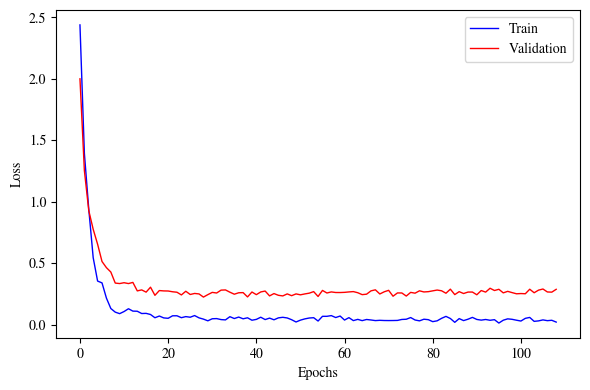

Plotting loss for TransE_FB15k-237_SGD


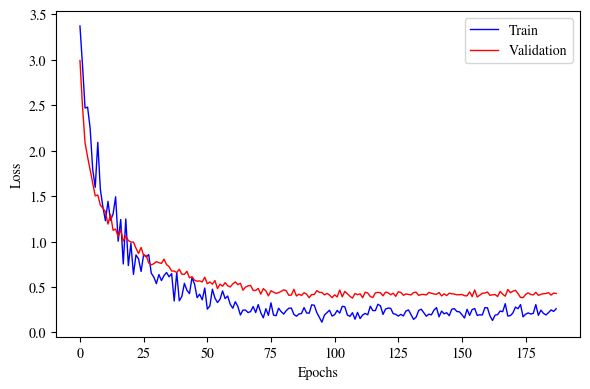

Plotting loss for TransE_WN18-RR_Adam


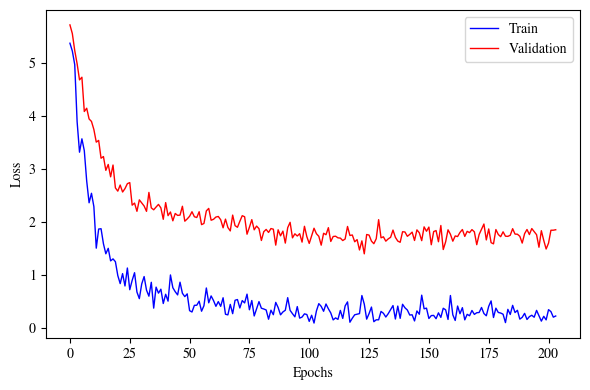

Plotting loss for TransE_WN18-RR_SGD


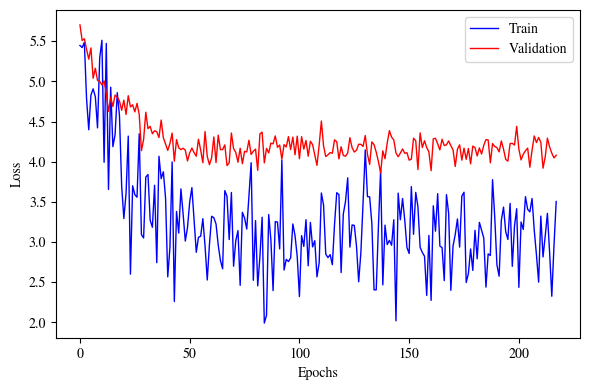

In [11]:
import matplotlib.pyplot as plt

for name in configs.keys():
    if DEBUG and name != 'DEBUG' or not DEBUG and name == 'DEBUG':
        continue
    print('=' * 80)
    print(f'Plotting loss for {name}')
    csv_path = os.path.join('output', name, 'loss.csv')
    if not os.path.exists(csv_path):
        print(f'No logs found for {name}, skipping')
        continue

    logs = pd.read_csv(csv_path)
    plt.figure(figsize=(6, 4))
    plt.plot(logs['loss'], color='b', linestyle='-', label='Train')
    plt.plot(logs['val_loss'], color='r', linestyle='-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
print('=' * 80)

## Evaluation

We report the model performance on link prediction task by computing Hits@10 metric on the test set.


### Hits@10

Following the evaluation protocol in the original paper, we first replace the head entity of a test triplet with entities in the dataset to generate corrupted triplets. Then, we compute the confidence scores of those corrupted triplets and check whether the correct triplet is ranked in the top 10. We report the proportion of correct triplets ranked in the top 10 as Hits@10 (Left). The whole procedure is repeated while replacing the tail entity instead of the head, resulting in Hits@10 (Right).

### Mean Reciprocal Rank (MRR)

We also report the MRR of the correct triplets, which is defined as the average of the reciprocal ranks of the correct triplets, i.e.

$$
\mathrm{MRR} = \frac{1}{|S|} \sum_{(h, r, t) \in S} \frac{1}{\mathrm{rank}_{(h, r, t)}}
$$

where $\mathrm{rank}_{(h, r, t)}$ is the rank of the correct triplet $(h, r, t)$ in the ranked list of all corrupted triplets.

### False Negative Filtering

When corrupting triplets for ranking, we may accidentally generate false negative samples which appear in the training/validation/testing set and thereby rank higher than the correct triplet. To avoid this misleading behavior, we filter out false negative samples by creating a lookup table as follows:

In [12]:
class FalseNegFilter:
    def __init__(self, dataset: TripletDataset):
        triplet_df = pd.DataFrame(
            np.concatenate(
                [
                    dataset.hrt_train,
                    dataset.hrt_val,
                    dataset.hrt_test,
                ]
            ),
            columns=['h', 'r', 't'],
        )
        self.n_entities = dataset.n_entities
        # given r and t, look up all positive h
        self.head_lookup_df = triplet_df.groupby(['r', 't'])['h'].apply(set)
        self.tail_lookup_df = triplet_df.groupby(['r', 'h'])['t'].apply(set)

    def head_mask(self, h, r, t):
        mask = np.zeros(self.n_entities, dtype=bool)
        if (r, t) in self.head_lookup_df:
            indices = list(self.head_lookup_df[r, t] - {h})
            mask[indices] = True
        return mask

    def tail_mask(self, h, r, t):
        mask = np.zeros(self.n_entities, dtype=bool)
        if (r, h) in self.tail_lookup_df:
            indices = list(self.tail_lookup_df[r, h] - {t})
            mask[indices] = True
        return mask

In [13]:
@tf.function
def predict_head_scores(model, r, t):
    '''
    Predict the scores of all possible heads given a relation and a tail.
    '''
    r = tf.repeat(r, model.n_entities)
    t = tf.repeat(t, model.n_entities)
    h = tf.range(model.n_entities)
    scores = model.score(tf.stack([h, r, t], axis=1))
    return scores


@tf.function
def predict_tail_scores(model, h, r):
    '''
    Predict the scores of all possible tails given a head and a relation.
    '''
    h = tf.repeat(h, model.n_entities)
    r = tf.repeat(r, model.n_entities)
    t = tf.range(model.n_entities)
    scores = model.score(tf.stack([h, r, t], axis=1))
    return scores


def compute_metrics(model, k, hrt, neg_filter: FalseNegFilter | None = None):
    '''
    Compute MRR and Hits@k.
    '''

    def func(i):
        h, r, t = hrt[i, 0], hrt[i, 1], hrt[i, 2]
        head_scores = predict_head_scores(model, r, t)
        tail_scores = predict_tail_scores(model, h, r)

        if neg_filter is not None:
            head_mask = neg_filter.head_mask(h, r, t)
            tail_mask = neg_filter.tail_mask(h, r, t)
            head_scores = np.where(head_mask, -np.inf, head_scores)
            tail_scores = np.where(tail_mask, -np.inf, tail_scores)

        rank_left = np.sum(head_scores > head_scores[h])
        rank_right = np.sum(tail_scores > tail_scores[t])
        rr_left = 1 / (rank_left + 1)
        rr_right = 1 / (rank_right + 1)
        hits_left = rank_left < k
        hits_right = rank_right < k
        return rr_left, rr_right, hits_left, hits_right

    mrr_left, mrr_right, hits_left, hits_right = zip(
        *[func(i) for i in tqdm(range(len(hrt)), leave=False)]
    )
    return (
        np.mean(mrr_left),
        np.mean(mrr_right),
        np.mean(hits_left),
        np.mean(hits_right),
    )


# Evaluation
for name, config in configs.items():
    if DEBUG and name != 'DEBUG' or not DEBUG and name == 'DEBUG':
        continue

    print('=' * 80)
    print(f'Evaluating model {name}')
    ckpt_path = os.path.join('output', name, 'checkpoint.keras')
    if not os.path.exists(ckpt_path):
        print(f'No checkpoint found for model {name}, skipping')
        continue

    model, dataset, train_ds, val_ds, test_ds = run_experiment(name, config)
    results = {}
    results['Training Loss'] = model.evaluate(train_ds, verbose=0)
    results['Validation Loss'] = model.evaluate(val_ds, verbose=0)
    results['Testing Loss'] = model.evaluate(test_ds, verbose=0)
    metrics = compute_metrics(
        model, k=10, hrt=dataset.hrt_test, neg_filter=FalseNegFilter(dataset)
    )
    results['MRR (Left)'] = metrics[0]
    results['MRR (Right)'] = metrics[1]
    results['MRR'] = (metrics[0] + metrics[1]) / 2
    results['Hits@10 (Left)'] = metrics[2]
    results['Hits@10 (Right)'] = metrics[3]
    results['Hits@10'] = (metrics[2] + metrics[3]) / 2
    for k, v in results.items():
        print(f'- {k:<20} {v:.4f}')
print('=' * 80)

Evaluating model TransE_FB15k-237_Adam
Using cached dataset at data/FB15k-237
Using pre-trained model at output/TransE_FB15k-237_Adam/checkpoint.keras


- Training Loss        0.0377
- Validation Loss      0.2622
- Testing Loss         0.2599
- MRR (Left)           0.1550
- MRR (Right)          0.3603
- MRR                  0.2577
- Hits@10 (Left)       0.2916
- Hits@10 (Right)      0.5364
- Hits@10              0.4140
Evaluating model TransE_FB15k-237_SGD
Using cached dataset at data/FB15k-237
Using pre-trained model at output/TransE_FB15k-237_SGD/checkpoint.keras


- Training Loss        0.1870
- Validation Loss      0.4312
- Testing Loss         0.4163
- MRR (Left)           0.1235
- MRR (Right)          0.3099
- MRR                  0.2167
- Hits@10 (Left)       0.2270
- Hits@10 (Right)      0.4707
- Hits@10              0.3489
Evaluating model TransE_WN18-RR_Adam
Using cached dataset at data/WN18-RR
Using pre-trained model at output/TransE_WN18-RR_Adam/checkpoint.keras


- Training Loss        0.4373
- Validation Loss      1.8209
- Testing Loss         1.7268
- MRR (Left)           0.2252
- MRR (Right)          0.2708
- MRR                  0.2480
- Hits@10 (Left)       0.5017
- Hits@10 (Right)      0.5626
- Hits@10              0.5321
Evaluating model TransE_WN18-RR_SGD
Using cached dataset at data/WN18-RR
Using pre-trained model at output/TransE_WN18-RR_SGD/checkpoint.keras


- Training Loss        1.6620
- Validation Loss      4.0798
- Testing Loss         4.0174
- MRR (Left)           0.0167
- MRR (Right)          0.0288
- MRR                  0.0228
- Hits@10 (Left)       0.0352
- Hits@10 (Right)      0.0622
- Hits@10              0.0487


### Comparison

We compare the performance of our trained model with the results from a relatively recent paper [(Nathani, et al. 2019)](https://doi.org/10.18653/v1/P19-1466)
, which are marked with asterisks in the following table.

|  Dataset  | Hits@10 (Ours) | Hits@10\* | MRR (Ours) | MRR\* |
| :-------: | :------------: | :-------: | :--------: | :---: |
| FB15k-237 |     0.445      |   0.441   |   0.278    | 0.279 |
|  WN18-RR  |     0.532      |   0.532   |   0.248    | 0.243 |

As we can see, our model reproduces the results on both the FB15k-237 and WN18-RR datasets, demonstrating the correctness of our implementation.

### Disclaimer

The results reported in the above table is obtained by running `train.ipynb` on the BitaHub server. On the other hand, the results in this notebook (`main.ipynb`) is trained on my local machine with a different hyperparameter setting, so you may see some slight differences in the printed information.

You can refer to `train.ipynb` for the exact training procedure and the `config` folder for the exact hyperparameter setting.